In [1]:
import findspark
# $ cd /opt
# /opt$ sudo ln -s ~/apps/spark-3.4.0-bin-hadoop3 spark
findspark.init("/opt/spark") 

In [2]:
# import pyspark
# sc = pyspark.SparkContext(appName="globalContent")

# pg_jar = str(Path('~/apps/postgresql-42.5.4.jar').expanduser().resolve())
# bq_jar = str(Path('~/apps/spark-bigquery-with-dependencies_2.12-0.30.0.jar').expanduser().resolve())
# spark_jars = f"{pg_jar},{bq_jar}"

from pyspark.sql import SparkSession
# spark = SparkSession.builder \
#             .appName("LensFeatures") \
#             .config("spark.jars", spark_jars) \
#             .getOrCreate()
spark = SparkSession.builder \
            .appName("LensFeatures") \
            .getOrCreate()

23/05/21 22:26:40 WARN Utils: Your hostname, VIJAYs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.87.20 instead (on interface en0)
23/05/21 22:26:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/21 22:26:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Prep data for training & testing

In [3]:
# posts_df = spark.read.format('com.google.cloud.spark.bigquery') \
#                     .option('table','lens-public-data.polygon.public_profile_post') \
#                     .load()
posts_df = spark.read.csv("/tmp/lens_bigquery_csvs/public_profile_post/", 
                          header=True, 
                          escape="\"",
                          multiLine=True,
                          inferSchema=True)

In [4]:
posts_df.printSchema()

root
 |-- post_id: string (nullable = true)
 |-- contract_publication_id: string (nullable = true)
 |-- profile_id: string (nullable = true)
 |-- content_uri: string (nullable = true)
 |-- s3_metadata_location: string (nullable = true)
 |-- collect_nft_address: string (nullable = true)
 |-- reference_implementation: string (nullable = true)
 |-- reference_return_data: string (nullable = true)
 |-- is_related_to_post: string (nullable = true)
 |-- is_related_to_comment: string (nullable = true)
 |-- is_metadata_processed: boolean (nullable = true)
 |-- has_error: boolean (nullable = true)
 |-- metadata_error_reason: string (nullable = true)
 |-- tx_hash: string (nullable = true)
 |-- is_hidden: boolean (nullable = true)
 |-- timeout_request: boolean (nullable = true)
 |-- app_id: string (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- created_block_hash: string (nullable = true)
 |-- metadata_version: string (nullable = true)
 |-- language: string (nullable = tru

In [5]:
# from pyspark.sql.functions import lit, current_timestamp, to_timestamp
# # ts = to_timestamp(lit('05-12-2023 00:00:00.000'),'MM-dd-yyyy HH:mm:ss.SSS')
# ts = current_timestamp()
# posts_df = posts_df \
#             .select("post_id") \
#             .withColumn("timestamp", ts)

from pyspark.sql.functions import col
posts_df = posts_df.select(col("post_id").alias("posts"))

In [6]:
! gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=MGbur2uZ7aGvSHrB5gK6yCIg4GkJMF&access_type=offline&code_challenge=yY_Oz5v6tyh1L1dwQCgZe5pZ5k4uDYJbpjVmp5IKaqM&code_challenge_method=S256


Credentials saved to file: [/Users/vijay/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "boxwood-well-386122" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the

In [7]:
PROJECT_ID = "boxwood-well-386122"
REGION = "us-central1"
BUCKET_URI = "gs://vijay-lens-feature-store-temp"  
from google.cloud import aiplatform
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [8]:
FEATURESTORE_ID = "lens_featurestore_dev"
from google.cloud.aiplatform import Feature, Featurestore
fs = Featurestore(
    featurestore_name=FEATURESTORE_ID
)
print(fs.gca_resource)

name: "projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev"
create_time {
  seconds: 1683658565
  nanos: 777177000
}
update_time {
  seconds: 1683730147
  nanos: 63762000
}
etag: "AMEw9yM3PtSfZY-vxAOoANe7rntqAYGFbrEQFv5SotKIt9w9kpjsztemlKPmdHF_-MI="
online_serving_config {
}
state: STABLE



In [9]:
posts_entity_type = fs.get_entity_type(entity_type_id="posts")

In [10]:
POSTS_FEATURES_IDS = {'posts': [feature.name for feature in posts_entity_type.list_features()]}
print(POSTS_FEATURES_IDS)

{'posts': ['region', 'class2', 'post_id', 'collects', 'author_f6c3m8col12enh_score', 'custom_filters_gardener_flagged', 'upvotes', 'content_warning', 'classes', 'mirrors', 'is_original', 'recommend', 'is_content_warning', 'class3', 'age', 'author_f6c3m8col12enh_rank', 'downvotes', 'main_content_focus', 'comments', 'class1', 'profile_id', 'language']}


In [11]:
INSTANCES_DF = posts_df.toPandas()

In [12]:
# google api expects a pandas Timestamp to be millisecond-aligned in RFC 3339 format 
# Example - 2012-07-30T10:43:17.123Z
import pandas as pd
from datetime import datetime
# ts = '2023-05-12T00:00:00.000Z'
ts = datetime.utcnow().isoformat(sep='T', timespec='milliseconds')+'Z'
INSTANCES_DF['timestamp'] = pd.Timestamp(ts)

In [13]:
INSTANCES_DF.head()

,posts,timestamp
0,0x01137e-0x01a8,2023-05-22 05:32:09.110000+00:00
1,0x01137e-0x01a9,2023-05-22 05:32:09.110000+00:00
2,0x01137e-0x01aa,2023-05-22 05:32:09.110000+00:00
3,0x01137e-0x01ab,2023-05-22 05:32:09.110000+00:00
4,0x01137e-0x01ac,2023-05-22 05:32:09.110000+00:00


In [14]:
INSTANCES_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   posts      452441 non-null  object             
 1   timestamp  452441 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 6.9+ MB


In [15]:
import datetime
from google.protobuf.timestamp_pb2 import Timestamp
# we had bad feature import on 5/11/2023, Let's ignore values from that date
bad_feature_time = datetime.datetime(year=2023, month=5, day=11, hour=0, minute=0, second=1)
START_TIME = Timestamp()
START_TIME.FromDatetime(bad_feature_time)
print(START_TIME)

seconds: 1683763201



In [16]:
# batch_serve_to_df(
#     serving_feature_ids: Dict[str, List[str]],
#     read_instances_df: pd.DataFrame,
#     pass_through_fields: Optional[List[str]] = None,
#     feature_destination_fields: Optional[Dict[str, str]] = None,
#     start_time: Optional[google.protobuf.timestamp_pb2.Timestamp] = None,
#     request_metadata: Optional[Sequence[Tuple[str, str]]] = (),
#     serve_request_timeout: Optional[float] = None,
#     bq_dataset_id: Optional[str] = None,
# )

features_df = fs.batch_serve_to_df(
    serving_feature_ids = POSTS_FEATURES_IDS,
    read_instances_df = INSTANCES_DF,
    start_time = START_TIME,
)

Serving Featurestore feature values: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev


INFO:google.cloud.aiplatform.featurestore.featurestore:Serving Featurestore feature values: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev


Serve Featurestore feature values backing LRO: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev/operations/6582259551188287488


INFO:google.cloud.aiplatform.featurestore.featurestore:Serve Featurestore feature values backing LRO: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev/operations/6582259551188287488


Featurestore feature values served. Resource name: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev


INFO:google.cloud.aiplatform.featurestore.featurestore:Featurestore feature values served. Resource name: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev


In [17]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   region                           362 non-null     object             
 3   class2                           0 non-null       float64            
 4   post_id                          452441 non-null  object             
 5   collects                         452441 non-null  int64              
 6   author_f6c3m8col12enh_score      450167 non-null  float64            
 7   custom_filters_gardener_flagged  452441 non-null  bool               
 8   upvotes                          452441 non-null  int64              
 9   content_warning                  72 non-null      object   

In [18]:
# data massaging to match features in the new lens_featurestore_d2 
features_df = features_df.rename(columns={"author_f6c3m8col12enh_score": "followship_score",
                                         "author_f6c3m8col12enh_rank": "followship_rank"})
features_df['followship_rank'] = features_df['followship_rank'].astype('Int64')

In [19]:
# data massaging to match features in the new lens_featurestore_d2 
features_df.drop(['class1', 'class2', 'class3', 'classes', 'post_id'], axis=1, inplace=True)

In [20]:
# data massaging to match features in the new lens_featurestore_d2 
features_df['entity_type_profiles'] = features_df['profile_id']

In [21]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   region                           362 non-null     object             
 3   collects                         452441 non-null  int64              
 4   followship_score                 450167 non-null  float64            
 5   custom_filters_gardener_flagged  452441 non-null  bool               
 6   upvotes                          452441 non-null  int64              
 7   content_warning                  72 non-null      object             
 8   mirrors                          452441 non-null  int64              
 9   is_original                      452441 non-null  bool     

## Compute post_score
IMPORTANT NOTE: Post_Score assigns a score to a post based on all the other posts by the same author. 

In [22]:
# assuming a 1->1 mapping between profile_id and followship_rank, 
# we use followship_rank because profile_id is not available in this featurestore
max_features = features_df \
                .groupby(["followship_rank"]) \
                .agg({'age': ['max'], 
                      'mirrors': ['max'], 
                      'collects': ['max'], 
                      'comments': ['max']})
max_features.columns = ['max_age', 'max_mirrors', 'max_collects', 'max_comments']

In [23]:
post_score_df = features_df.join(max_features, on='followship_rank', how='left')

In [24]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   region                           362 non-null     object             
 3   collects                         452441 non-null  int64              
 4   followship_score                 450167 non-null  float64            
 5   custom_filters_gardener_flagged  452441 non-null  bool               
 6   upvotes                          452441 non-null  int64              
 7   content_warning                  72 non-null      object             
 8   mirrors                          452441 non-null  int64              
 9   is_original                      452441 non-null  bool     

In [25]:
import pandas as pd
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns', 200)  
pd.set_option('display.float_format', '{:20,.20f}'.format)
post_score_df.sample(5)

,timestamp,entity_type_posts,region,collects,followship_score,custom_filters_gardener_flagged,upvotes,content_warning,mirrors,is_original,recommend,is_content_warning,age,followship_rank,downvotes,main_content_focus,comments,profile_id,language,entity_type_profiles,max_age,max_mirrors,max_collects,max_comments
447013,2023-05-22 05:32:09.110000+00:00,0x012629-0x02,None,0,0.00000000001669779536,False,1,None,0,True,None,False,41,101908,0,TEXT_ONLY,0,None,zh,None,226.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
273351,2023-05-22 05:32:09.110000+00:00,0x0128be-0x1e,None,7,0.00000069852715215989,False,9,None,0,True,None,False,86,10698,0,TEXT_ONLY,0,None,en,None,92.00000000000000000000,6.00000000000000000000,7.00000000000000000000,11.00000000000000000000
301278,2023-05-22 05:32:09.110000+00:00,0x01218c-0x1a,None,0,0.00000815905570527384,False,2,None,0,True,None,False,202,2848,0,TEXT_ONLY,0,None,en,None,226.00000000000000000000,9.00000000000000000000,10.00000000000000000000,7.00000000000000000000
143828,2023-05-22 05:32:09.110000+00:00,0x011a7a-0x16,None,1,0.00000007717485845198,False,4,None,0,True,None,False,105,27892,0,IMAGE,0,None,en,None,122.00000000000000000000,1.00000000000000000000,2.00000000000000000000,1.00000000000000000000
212097,2023-05-22 05:32:09.110000+00:00,0x0128a6-0x0f,None,0,0.00000035599544811145,False,0,None,0,False,None,False,94,15088,0,TEXT_ONLY,0,None,en,None,217.00000000000000000000,3.00000000000000000000,2.00000000000000000000,2.00000000000000000000


In [26]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')  
pd.reset_option('display.float_format')

In [27]:
import numpy as np
post_score_df['max_mirrors'] = post_score_df['max_mirrors'].replace(0, np.nan)
post_score_df['max_collects'] = post_score_df['max_collects'].replace(0, np.nan)
post_score_df['max_comments'] = post_score_df['max_comments'].replace(0, np.nan)
post_score_df['max_age'] = post_score_df['max_age'].replace(0, np.nan)

In [28]:
# (1 * (mirrors_count::numeric / max_values.max_mirrors_count) +
# 1 * (collects_count::numeric / max_values.max_collects_count) +
# 3 * (comments_count::numeric / max_values.max_comments_count) -
# 5 * ((EXTRACT(EPOCH FROM (CURRENT_TIMESTAMP - block_timestamp))/(60*60*24)) / max_values.max_age_days)
# ) AS score

def calc_post_score(row):
    # avoid ZeroDivisionError
    return 1 * row['mirrors']/(row['max_mirrors'] if row['max_mirrors'] > 0 else 1e10) \
            + 1 * row['collects']/(row['max_collects'] if row['max_collects'] > 0 else 1e10) \
            + 3 * row['comments']/(row['max_comments'] if row['max_comments'] > 0 else 1e10) \
            - 5 * row['age']/(row['max_age'] if row['max_age'] > 0 else 1e10)

post_score_df['post_score'] = post_score_df.apply(calc_post_score, axis=1)

# post_score_df['post_score'] = post_score_df.apply(lambda row: (1 * row['mirrors']/row['max_mirrors'] \
#                                                             + 1 * row['collects']/row['max_collects'] \
#                                                             + 3 * row['comments']/row['max_comments'] \
#                                                             - 5 * row['age']/row['max_age']), 
#                                                   axis=1)

In [29]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   region                           362 non-null     object             
 3   collects                         452441 non-null  int64              
 4   followship_score                 450167 non-null  float64            
 5   custom_filters_gardener_flagged  452441 non-null  bool               
 6   upvotes                          452441 non-null  int64              
 7   content_warning                  72 non-null      object             
 8   mirrors                          452441 non-null  int64              
 9   is_original                      452441 non-null  bool     

In [30]:
post_score_df = post_score_df.sort_values(['post_score'], ascending=[False])

In [31]:
top_posts_df = post_score_df.loc[post_score_df['followship_rank'] <= 1000 ].head(1000)

In [32]:
len(top_posts_df)

1000

In [33]:
post_score_df['followship_rank'].max()

103050

In [34]:
post_score_df['followship_rank'].min()

4

In [35]:
post_score_df.head()

,timestamp,entity_type_posts,region,collects,followship_score,custom_filters_gardener_flagged,upvotes,content_warning,mirrors,is_original,...,main_content_focus,comments,profile_id,language,entity_type_profiles,max_age,max_mirrors,max_collects,max_comments,post_score
336826,2023-05-22 05:32:09.110000+00:00,0x011f9a-0x01e2,None,3,1.171225e-06,False,6,None,5,True,...,IMAGE,3,None,id,None,192.0,5.0,3.0,3.0,4.609375
391054,2023-05-22 05:32:09.110000+00:00,0x012788-0x0105,None,21,8.631997e-07,False,97,None,90,True,...,IMAGE,8,None,vi,None,221.0,90.0,21.0,8.0,4.592760
267208,2023-05-22 05:32:09.110000+00:00,0x012828-0x018f,None,50,3.114084e-04,False,316,None,87,True,...,TEXT_ONLY,137,None,en,None,225.0,87.0,65.0,137.0,4.591453
9197,2023-05-22 05:32:09.110000+00:00,0x012751-0xc4,None,9,3.195345e-07,False,23,None,5,True,...,IMAGE,5,None,None,None,226.0,5.0,9.0,5.0,4.491150
210874,2023-05-22 05:32:09.110000+00:00,0x011af6-0x23,None,43,1.743990e-05,False,133,None,82,True,...,VIDEO,15,None,en,None,189.0,82.0,43.0,15.0,4.470899


## Labeling data based on heuristics
We assume that posts by top 1000 profiles (as ranked by EigenTrust) are noteworthy and could be recommended to users.

In [36]:
# conditions = [
#     (df['followship_rank'] <= 1000) & 
#     ]
# # create a list of the values we want to assign for each condition
# values = [True]
# post_score_df['recommend'] = np.select(conditions, values, default=False)
# post_score_df.loc['recommend'] = np.nan
post_score_df.loc[post_score_df['followship_rank'] >= 50000, 'recommend'] = 'NO'
post_score_df.loc[post_score_df['followship_rank'] <= 1000, 'recommend'] = 'MAYBE'
post_score_df.loc[top_posts_df.index,'recommend'] = 'YES'

In [37]:
# labeled data
post_score_df['recommend'].value_counts()

recommend
NO       45067
MAYBE    12556
YES       1000
Name: count, dtype: int64

In [38]:
# unlabeled data
post_score_df['recommend'].isna().sum()

393818

In [39]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452441 entries, 336826 to 452439
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   region                           362 non-null     object             
 3   collects                         452441 non-null  int64              
 4   followship_score                 450167 non-null  float64            
 5   custom_filters_gardener_flagged  452441 non-null  bool               
 6   upvotes                          452441 non-null  int64              
 7   content_warning                  72 non-null      object             
 8   mirrors                          452441 non-null  int64              
 9   is_original                      452441 non-null  bool     

In [40]:
# we don't want ids and timestamp to affect the model training
# we need to capture the concept of time through the age feature.
# TODO FIXME - remove age from the featurestore. it should be recomputed at the time of training and prediction
post_ids_df = post_score_df['entity_type_posts']
post_score_df.drop([
                    'timestamp', 
                    'entity_type_posts',
                    'profile_id',
                    'entity_type_profiles'
                   ], 
                   axis=1, inplace=True)

In [41]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452441 entries, 336826 to 452439
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   region                           362 non-null     object 
 1   collects                         452441 non-null  int64  
 2   followship_score                 450167 non-null  float64
 3   custom_filters_gardener_flagged  452441 non-null  bool   
 4   upvotes                          452441 non-null  int64  
 5   content_warning                  72 non-null      object 
 6   mirrors                          452441 non-null  int64  
 7   is_original                      452441 non-null  bool   
 8   recommend                        58623 non-null   object 
 9   is_content_warning               452441 non-null  bool   
 10  age                              452441 non-null  int64  
 11  followship_rank                  450167 non-null  Int64  
 12  do

In [42]:
post_ids_df.info()

<class 'pandas.core.series.Series'>
Index: 452441 entries, 336826 to 452439
Series name: entity_type_posts
Non-Null Count   Dtype 
--------------   ----- 
452441 non-null  object
dtypes: object(1)
memory usage: 23.0+ MB


In [43]:
# just making sure datatypes are correct
post_score_df['collects'] = post_score_df['collects'].astype('Int64')
post_score_df['custom_filters_gardener_flagged'] = post_score_df['custom_filters_gardener_flagged'].astype('bool')
post_score_df['upvotes'] = post_score_df['upvotes'].astype('Int64')
post_score_df['mirrors'] = post_score_df['mirrors'].astype('Int64')
post_score_df['is_original'] = post_score_df['is_original'].astype('bool')
post_score_df['is_content_warning'] = post_score_df['is_content_warning'].astype('bool')
post_score_df['age'] = post_score_df['age'].astype('Int64')
post_score_df['downvotes'] = post_score_df['downvotes'].astype('Int64')
post_score_df['comments'] = post_score_df['comments'].astype('Int64')
post_score_df['downvotes'] = post_score_df['downvotes'].astype('Int64')
post_score_df['max_age'] = post_score_df['max_age'].astype('Int64')
post_score_df['max_mirrors'] = post_score_df['max_mirrors'].astype('Int64')
post_score_df['max_collects'] = post_score_df['max_collects'].astype('Int64')
post_score_df['max_comments'] = post_score_df['max_comments'].astype('Int64')

In [44]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452441 entries, 336826 to 452439
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   region                           362 non-null     object 
 1   collects                         452441 non-null  Int64  
 2   followship_score                 450167 non-null  float64
 3   custom_filters_gardener_flagged  452441 non-null  bool   
 4   upvotes                          452441 non-null  Int64  
 5   content_warning                  72 non-null      object 
 6   mirrors                          452441 non-null  Int64  
 7   is_original                      452441 non-null  bool   
 8   recommend                        58623 non-null   object 
 9   is_content_warning               452441 non-null  bool   
 10  age                              452441 non-null  Int64  
 11  followship_rank                  450167 non-null  Int64  
 12  do

# Train Model

In [45]:
ground_truth_df = post_score_df[post_score_df['recommend'].notna()]

In [46]:
ground_truth_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58623 entries, 267208 to 452439
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   region                           73 non-null     object 
 1   collects                         58623 non-null  Int64  
 2   followship_score                 58623 non-null  float64
 3   custom_filters_gardener_flagged  58623 non-null  bool   
 4   upvotes                          58623 non-null  Int64  
 5   content_warning                  7 non-null      object 
 6   mirrors                          58623 non-null  Int64  
 7   is_original                      58623 non-null  bool   
 8   recommend                        58623 non-null  object 
 9   is_content_warning               58623 non-null  bool   
 10  age                              58623 non-null  Int64  
 11  followship_rank                  58623 non-null  Int64  
 12  downvotes        

In [47]:
# Extract feature and target arrays
X, y = ground_truth_df.drop('recommend', axis=1), ground_truth_df[['recommend']]

In [48]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    X[col] = X[col].astype('category')

In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58623 entries, 267208 to 452439
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   region                           73 non-null     category
 1   collects                         58623 non-null  Int64   
 2   followship_score                 58623 non-null  float64 
 3   custom_filters_gardener_flagged  58623 non-null  category
 4   upvotes                          58623 non-null  Int64   
 5   content_warning                  7 non-null      category
 6   mirrors                          58623 non-null  Int64   
 7   is_original                      58623 non-null  category
 8   is_content_warning               58623 non-null  category
 9   age                              58623 non-null  Int64   
 10  followship_rank                  58623 non-null  Int64   
 11  downvotes                        58623 non-null  Int64   
 12  mai

In [50]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58623 entries, 267208 to 452439
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   recommend  58623 non-null  object
dtypes: object(1)
memory usage: 916.0+ KB


In [51]:
y['recommend'].value_counts()

recommend
NO       45067
MAYBE    12556
YES       1000
Name: count, dtype: int64

In [52]:
from sklearn.preprocessing import OrdinalEncoder
# Encode y to numeric
enc = OrdinalEncoder()
y_encoded = enc.fit_transform(y)

In [53]:
y_encoded

array([[2.],
       [1.],
       [2.],
       ...,
       [1.],
       [1.],
       [1.]])

In [54]:
enc.categories_

[array(['MAYBE', 'NO', 'YES'], dtype=object)]

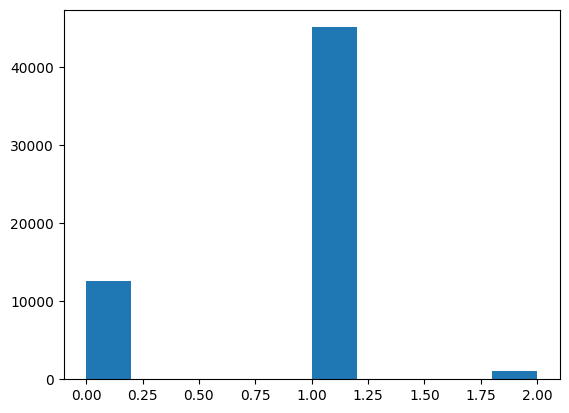

In [55]:
import matplotlib.pyplot as plt
plt.hist(y_encoded)
plt.show()

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)

In [57]:
import xgboost as xgb
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [58]:
# multi:softprob if we want to get probabilities for each class
# multi:softmax if we just need the class that has the highest probability
params = {"objective": "multi:softmax", "tree_method": "hist", "num_class": 3}
n = 100 

evals = [(dtest_clf, "validation"), (dtrain_clf, "train")]

model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10
)

[0]	validation-mlogloss:0.70243	train-mlogloss:0.70234
[10]	validation-mlogloss:0.02781	train-mlogloss:0.02746
[20]	validation-mlogloss:0.00171	train-mlogloss:0.00145
[30]	validation-mlogloss:0.00032	train-mlogloss:0.00014
[40]	validation-mlogloss:0.00027	train-mlogloss:0.00005
[50]	validation-mlogloss:0.00029	train-mlogloss:0.00004
[60]	validation-mlogloss:0.00030	train-mlogloss:0.00004
[70]	validation-mlogloss:0.00031	train-mlogloss:0.00004
[80]	validation-mlogloss:0.00032	train-mlogloss:0.00004
[90]	validation-mlogloss:0.00034	train-mlogloss:0.00004
[99]	validation-mlogloss:0.00034	train-mlogloss:0.00004


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

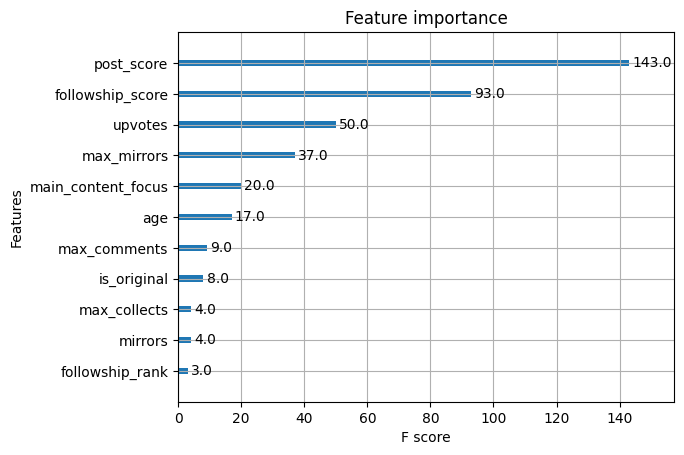

In [59]:
from xgboost import plot_importance
plot_importance(model)

# Save Trained model and encoder for future use

In [60]:
from datetime import datetime
train_date_str = datetime.utcnow().strftime('%Y%m%d%H%M%S')
model_filename = f"{train_date_str}_model.json"
enc_filename = f'{train_date_str}_recommend_encoder.pkl'
print(model_filename)
print(enc_filename)

20230522053757_model.json
20230522053757_recommend_encoder.pkl


In [61]:
model.save_model(model_filename)

In [62]:
import pickle
pickle.dump(enc, open(enc_filename, 'wb'))

# Use previously trained model to make predictions

In [63]:
# model_filename = "20230522053757_model.json"
model_p = xgb.Booster()
model_p.load_model(model_filename)

In [64]:
# enc_filename = '20230522053757_recommend_encoder.pkl'
enc = pickle.load(open(enc_filename, 'rb'))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

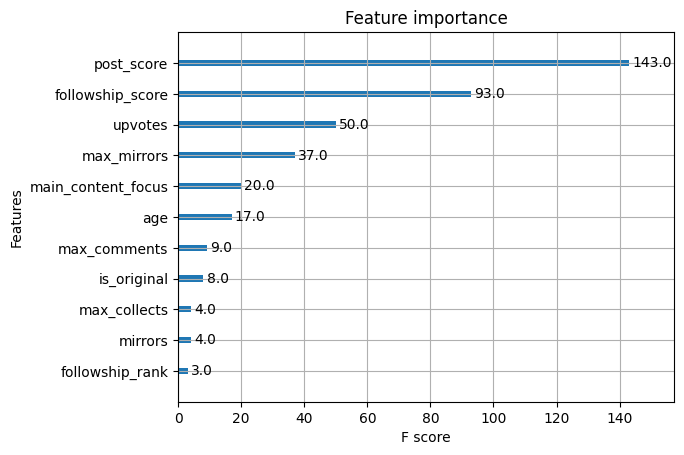

In [65]:
from xgboost import plot_importance
plot_importance(model_p)

In [66]:
# restore post_id back into dataframe so we can use for testing predictions
import pandas as pd
post_score_df = pd.merge(post_score_df, post_ids_df, left_index=True, right_index=True)

In [67]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452441 entries, 336826 to 452439
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   region                           362 non-null     object 
 1   collects                         452441 non-null  Int64  
 2   followship_score                 450167 non-null  float64
 3   custom_filters_gardener_flagged  452441 non-null  bool   
 4   upvotes                          452441 non-null  Int64  
 5   content_warning                  72 non-null      object 
 6   mirrors                          452441 non-null  Int64  
 7   is_original                      452441 non-null  bool   
 8   recommend                        58623 non-null   object 
 9   is_content_warning               452441 non-null  bool   
 10  age                              452441 non-null  Int64  
 11  followship_rank                  450167 non-null  Int64  
 12  do

In [68]:
input_df = post_score_df[post_score_df['recommend'].isna()]
input_df, input_df_ids = input_df.drop('entity_type_posts', axis=1), input_df[['entity_type_posts']]

In [69]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393818 entries, 336826 to 452176
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   region                           289 non-null     object 
 1   collects                         393818 non-null  Int64  
 2   followship_score                 391544 non-null  float64
 3   custom_filters_gardener_flagged  393818 non-null  bool   
 4   upvotes                          393818 non-null  Int64  
 5   content_warning                  65 non-null      object 
 6   mirrors                          393818 non-null  Int64  
 7   is_original                      393818 non-null  bool   
 8   recommend                        0 non-null       object 
 9   is_content_warning               393818 non-null  bool   
 10  age                              393818 non-null  Int64  
 11  followship_rank                  391544 non-null  Int64  
 12  do

In [70]:
input_df_ids.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393818 entries, 336826 to 452176
Data columns (total 1 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   entity_type_posts  393818 non-null  object
dtypes: object(1)
memory usage: 6.0+ MB


In [71]:
input_df = input_df.drop('recommend', axis=1)

In [72]:
cats = input_df.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    input_df[col] = input_df[col].astype('category')

In [73]:
dinput_df = xgb.DMatrix(input_df, enable_categorical=True)

In [74]:
predicted_y = model_p.predict(dinput_df)

In [75]:
len(predicted_y)

393818

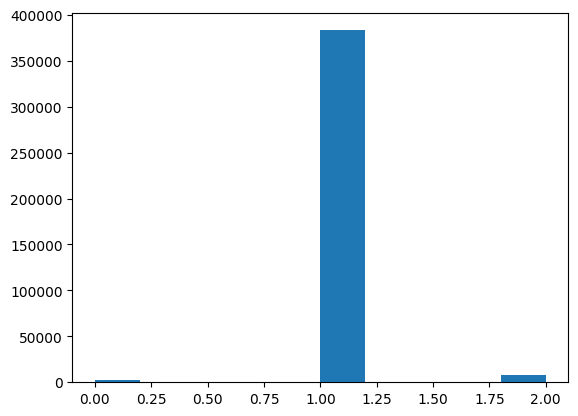

In [76]:
import matplotlib.pyplot as plt
plt.hist(predicted_y)
plt.show()

In [ ]:
import numpy as np
predicted_y_int = np.rint(predicted_y)

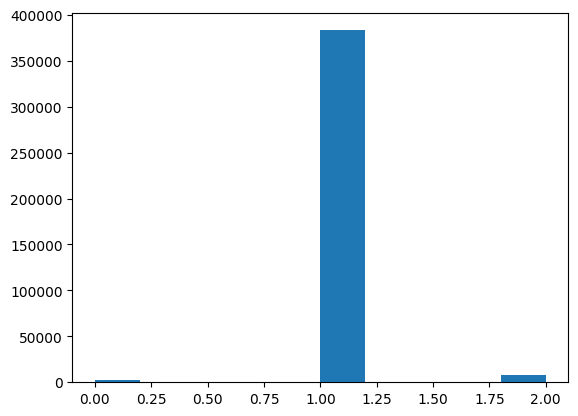

In [78]:
import matplotlib.pyplot as plt
plt.hist(predicted_y_int)
plt.show()

In [79]:
predicted_y_int

array([2., 2., 2., ..., 1., 1., 1.], dtype=float32)

In [80]:
enc.categories_

[array(['MAYBE', 'NO', 'YES'], dtype=object)]

In [81]:
# sklearn encoder inverse_transform requires a 2D array
predicted_y_int = enc.inverse_transform(predicted_y_int.reshape(-1, 1))

In [82]:
# convert back from 2D array to 1D array so we can add column to Dataframe
predicted_y_int = predicted_y_int.reshape(-1)

In [83]:
predicted_y_int

array(['YES', 'YES', 'YES', ..., 'NO', 'NO', 'NO'], dtype=object)

In [84]:
input_df['recommend'] = predicted_y_int

In [85]:
input_df['recommend'].value_counts()

recommend
NO       383133
YES        8411
MAYBE      2274
Name: count, dtype: int64

In [86]:
yes_fraction = round(80 / input_df['recommend'].value_counts()['YES'], 2)
print(yes_fraction)

maybe_fraction = round(20 / input_df['recommend'].value_counts()['MAYBE'], 2)
print(maybe_fraction)

0.01
0.01


In [87]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393818 entries, 336826 to 452176
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   region                           289 non-null     category
 1   collects                         393818 non-null  Int64   
 2   followship_score                 391544 non-null  float64 
 3   custom_filters_gardener_flagged  393818 non-null  category
 4   upvotes                          393818 non-null  Int64   
 5   content_warning                  65 non-null      category
 6   mirrors                          393818 non-null  Int64   
 7   is_original                      393818 non-null  category
 8   is_content_warning               393818 non-null  category
 9   age                              393818 non-null  Int64   
 10  followship_rank                  391544 non-null  Int64   
 11  downvotes                        393818 non-null  In

In [88]:
# if there are NaN, converting pandas to pyspark fails with error
# can not merge type <class 'pyspark.sql.types.longtype'> and <class 'pyspark.sql.types.structtype'>
# followship_rank 0 does not make sense so let's set it to a very large value
# all other columns, set nan to 0
input_df['followship_rank'] = input_df['followship_rank'].fillna(1e10)
# can't fillna on categorical columns. so, get just the int columns
int_cols = input_df.select_dtypes(include=np.number).columns.tolist()
for col in int_cols:
    input_df.fillna(0)

In [89]:
import pandas as pd
output_df = pd.merge(input_df, input_df_ids, left_index=True, right_index=True)
output_df = output_df.rename(columns={'entity_type_posts': 'post_id'})

In [90]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393818 entries, 336826 to 452176
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   region                           289 non-null     category
 1   collects                         393818 non-null  Int64   
 2   followship_score                 391544 non-null  float64 
 3   custom_filters_gardener_flagged  393818 non-null  category
 4   upvotes                          393818 non-null  Int64   
 5   content_warning                  65 non-null      category
 6   mirrors                          393818 non-null  Int64   
 7   is_original                      393818 non-null  category
 8   is_content_warning               393818 non-null  category
 9   age                              393818 non-null  Int64   
 10  followship_rank                  393818 non-null  Int64   
 11  downvotes                        393818 non-null  In

In [91]:
recommend_df = spark.createDataFrame(
                    output_df[['post_id', 'recommend',
                              'followship_rank', 'followship_score',
                              'post_score']])

In [92]:
posts_df = spark.read.csv("/tmp/lens_bigquery_csvs/public_profile_post/", 
                          header=True, 
                          escape="\"",
                          multiLine=True,
                          inferSchema=True)

In [93]:
# rename post_id column to avoid name conflict after join
recommend_df = recommend_df.withColumnRenamed('post_id', 'recommend_post_id')

posts_recommend_df = posts_df.join(recommend_df, posts_df.post_id == recommend_df.recommend_post_id, "leftouter")

In [94]:
recommendations = posts_recommend_df \
            .sampleBy('recommend', {'YES': yes_fraction, 'MAYBE': maybe_fraction}, 0)

In [95]:
recommendations.count()

23/05/21 22:42:59 WARN TaskSetManager: Stage 6 contains a task of very large size (4153 KiB). The maximum recommended task size is 1000 KiB.


101

In [96]:
recommendations.select(
    'post_id', 'language', 'content', 'recommend',
    'followship_rank', 'post_score',
    'custom_filters_gardener_flagged', 'main_content_focus').show(100, truncate = False)

23/05/21 22:43:10 WARN TaskSetManager: Stage 15 contains a task of very large size (4153 KiB). The maximum recommended task size is 1000 KiB.


+-------------------------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------------+--------------------+-------------------------------+------------------+
|post_id                  |language|content                                                                                                                                                                           